# 平均合意プロトコルにおける収束加速

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [59]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using LightGraphs
using GraphPlot
using Cairo, Compose

### 準備 (グローバル定数の設定)

この例ではKarateグラフを例として利用する。

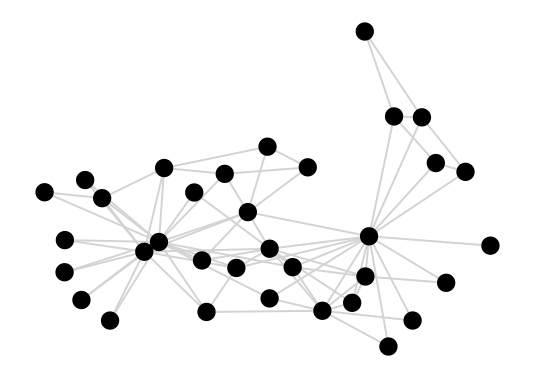

In [60]:
n = 34
g = smallgraph("karate")
L = Matrix(laplacian_matrix(g)) + 1e-12*I 
eig = eigvals(L)
lmin = eig[2]
lmax = eig[n]
η_opt = 2.0/(lmin + lmax)

K = 200
num_itr = 75
adam_lr = 5e-4
max_inner = 50

gplot(g, nodefillc="black")

### ミニバッチ生成関数

ミニバッチ生成関数の返り値は、ノード初期値とその平均値ベクトルからなるミニバッチとなる。

In [61]:
function mini_batch(K)
    x0 = randn(n, K)
    r = zeros(n, K)
    c = sum(x0, dims=1)
    for j in 1:K
        r[:,j] = c[j]*ones(n)/n
    end
    return x0, r
end

mini_batch (generic function with 1 method)

### 固定ステップサイズの平均合意プロトコル (普通のコンセンサスプロトコル)

In [62]:
function consensus(max_itr, x0)
    x = x0
    for i in 1:max_itr
        x = (I - η_opt*L)*x
    end
    return x
end

function comp_mse(max_itr)
    x0, c = mini_batch(K)
    x̂ = consensus(max_itr, x0)
    return norm(c-x̂)^2/K
end

comp_mse (generic function with 1 method)

### 合意状態からの誤差(MSE)のプロット

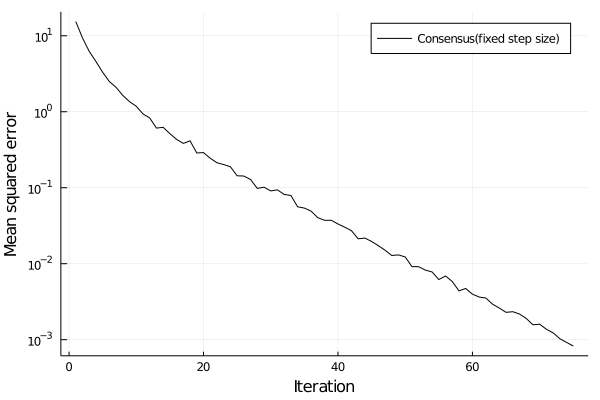

In [63]:
consensus_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, consensus_mse, lw=1, yscale=:log10, label="Consensus(fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-consensus反復の定義

In [64]:
function DU_consensus(max_itr, x0, η)
    x = x0
    for i in 1:max_itr
        x = (I - η[i]*L)*x
    end
    return x
end

DU_consensus (generic function with 1 method)

### 損失関数の定義

In [65]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end 

loss (generic function with 1 method)

### 訓練関数の定義

In [66]:
function train(opt, η)
    ps = params(η) 
    for itr in 1:num_itr
        for i in 1:max_inner
            y, x_opt = mini_batch(K)
            gs = gradient(ps) do
                x_hat = DU_consensus(itr, y, η)
                loss(x_opt, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        y, x_opt = mini_batch(K)
        x_est = DU_consensus(itr, y, η)
        println(itr, " ", loss(x_opt, x_est))
    end
end

train (generic function with 1 method)

In [67]:
function comp_mse_DU_consensus(max_itr, η)
    x0, c = mini_batch(K)
    x̂ = DU_consensus(max_itr, x0, η)
    return loss(c, x̂)
end

comp_mse_DU_consensus (generic function with 1 method)

### 学習過程

1 25.921817322153608
2 17.3607994216523
3 11.406498175465517
4 7.248093458623447
5 4.73329331884576
6 2.8744565344095143
7 2.0271022465520745
8 1.289152441808771
9 0.8201512445905411
10 0.704647524247285
11 0.5487177383002121
12 0.4351698777567391
13 0.3322574386907802
14 0.2585164079683762
15 0.20641175845135834
16 0.14941949410599237
17 0.15098498968277607
18 0.12345612937527699
19 0.09875325760777008
20 0.07464871222288613
21 0.06591964386458196
22 0.05957070221116949
23 0.04531426330204404
24 0.14125571122343886
25 0.04613995661220098
26 0.037860685335426046
27 0.027003575894004865
28 0.02015524418828264
29 0.017133779752600425
30 0.011777543172020928
31 0.01611418151223764
32 0.013750581302628118
33 0.010845774872901113
34 0.009872525555573745
35 0.006746424726520084
36 0.005129546398363519
37 0.004828391778930533
38 0.0036017238245357837
39 0.002974557050315108
40 0.0029978640954962587
41 0.002600679352520843
42 0.002510566758229737
43 0.002164298525986826
44 0.001215088270644145

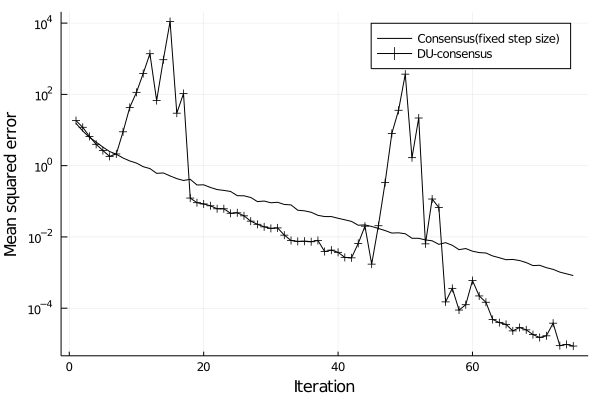

In [68]:
η_train = zeros(num_itr)
opt = ADAM(adam_lr)
train(opt, η_train)
DU_consensus_mse =[comp_mse_DU_consensus(i, η_train) for i in 1:num_itr]
plot!(1:num_itr, DU_consensus_mse, lw=1, label="DU-consensus", color=:black, marker=:+)

In [69]:
savefig("DU-consensus.pdf")

In [70]:
draw(PDF("karate.pdf", 8cm, 8cm), gplot(g, nodefillc="black"))